# TP 2 : Signature Plot, Epps Effect and Link between Spread and Volatility per trade

### By Zhiyuan XU and Wenjun LIU

## I. Volatility Estimator and Signature Plot

### 1. Signature Plot

Let $P$ be the price process, $X=\log P$ be the log-price process and $\Delta$ the discretization step over a time period $[0,T]$. Set for every $j\in{1,\ldots,T/\Delta}$, $r_{\Delta}(j)=X_{\Delta j}-X_{\Delta(j-1)}$ the log-price increments. Thus, in the Itô semi-martingale framework, the integrated variance reads
$$\int_0^T\sigma^2_sds=\lim_{\Delta\to0}\sum_{j=1}^{T/\Delta}r_{\Delta}(j)^2.$$
Consequently, a "natural" estimator for the integrated variance is 
$$\hat{V}_R(\Delta)=\sum_{j=1}^{T/\Delta}r_{\Delta}(j)^2.$$
This estimator is consistent since 
$$\hat{V}_R(\Delta)\overset{\mathbb{P}}{\underset{\Delta\to0}{\longrightarrow}}\int_0^T\sigma^2_sds.$$

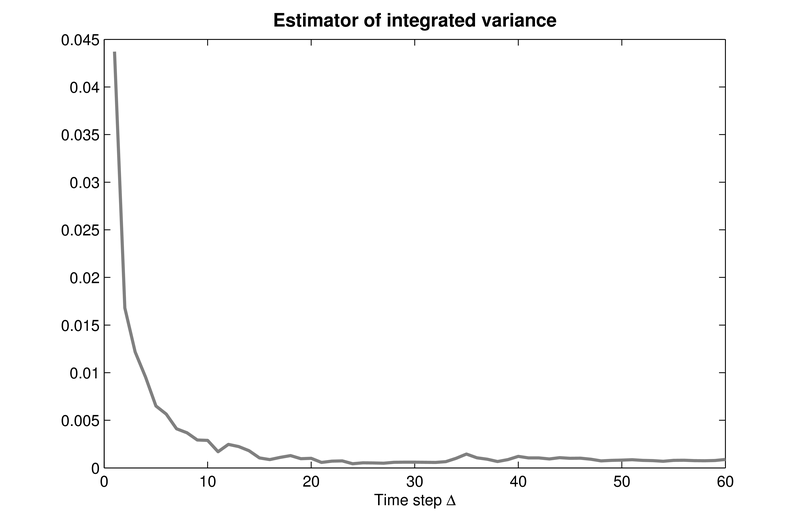

In [2]:
from IPython.display import Image
Image(filename='imgs/SignaturePlot.png', width=500)

_Estimator for the integrated variance computed for Rio Tinto between 03/01/2012 and 19/06/2012 according to the time discretization step._

They are many other ways to estimate the volatility: for example by using the minimum and the maximum of the price (see Garman & Klass), by considering multi-scale (see Ait-Sahalia or Ait-Sahalia & Jacod}) or by bid-ask modeling (see Robert & Rosenbaum).

**Observations and microstructure.** A model for log-price observation $X$ may be $X=M+\varepsilon$, where $M$ is a semi-martingale and $\varepsilon$ is the noise. Consequently
$$r_{\Delta}(j)=M_{\Delta j}-M_{\Delta(j-1)}+\varepsilon_{\Delta j}-\varepsilon_{\Delta(j-1)}=r^M_{\Delta}(j)+\eta_{\Delta}(j).$$
Thus the realized varince reads
$$\hat{V}_R(\Delta)=\sum_{j=1}^{T/\Delta}r_{\Delta}(j)^2=\sum_{j=1}^{T/\Delta}r^M_{\Delta}(j)^2+\sum_{j=1}^{T/\Delta}\eta_{\Delta}(j)^2+\sum_{j=1}^{T/\Delta}r^M_{\Delta}(j)\eta_{\Delta}(j).$$
This estimator diverges when $\Delta\to0$.

<font color='blue'>**To do.** Plot $\hat{V}_R(\Delta)$ with respect to $\Delta$ (in minutes and seconds) for one asset. Do it for the mid-price and the log-mid-price. Comment the results.</font>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
import statsmodels.api as sm
from tqdm import tqdm

In [4]:
Chemin = "Data"

In [5]:
def calcul_vol(PriceSec,deltaT):
    sampled = PriceSec[::deltaT]
    diff_somme = ((sampled - sampled.shift(-1))**2).fillna(0)
    return diff_somme.sum()

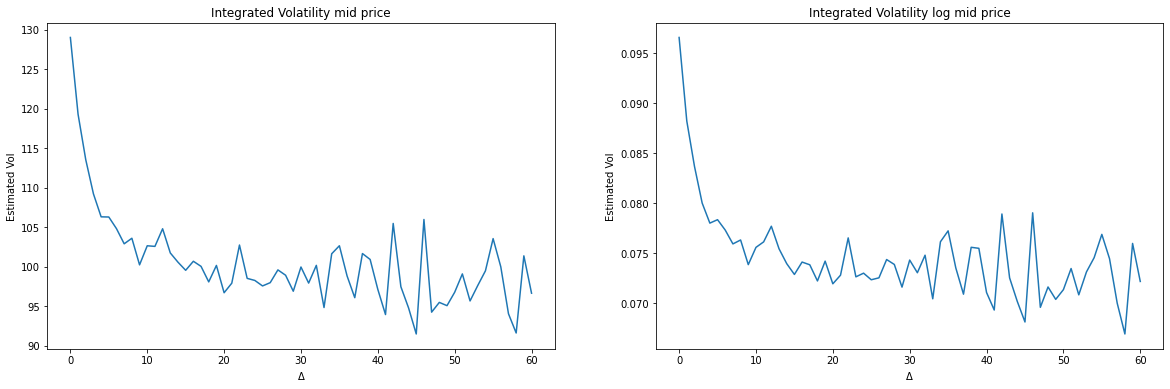

In [6]:
def signature(StockName,ran,mode='normal'):
    stock  = pd.read_hdf(Chemin+'/'+StockName+'.h5')
    stock['MidPrice'] = (stock['BidPrice'] + stock['AskPrice'])/2
    PriceSec = stock['MidPrice'].resample('1s').first().fillna(method='ffill')
    if mode == 'log':
        PriceSec = np.log(PriceSec)
    ans = []

    for i in ran:
        ans.append(calcul_vol(PriceSec,i))
    return ans
# T = 1000
ran = range(5, 12200, 200)
StockName = 'TOTAL'
f, axs = plt.subplots(1, 2, figsize=(20,6))
axs[0].plot(signature(StockName,ran,mode='normal'))
axs[0].set_title('Integrated Volatility mid price')
axs[0].set_xlabel('$\Delta$')
axs[0].set_ylabel('Estimated Vol')
axs[1].plot(signature(StockName,ran,mode='log'))
axs[1].set_title('Integrated Volatility log mid price')
axs[1].set_xlabel('$\Delta$')
axs[1].set_ylabel('Estimated Vol')
plt.show()

Commentaire:


À partir des graphes dessus, on peut constater la décroissance de la volatilité intégrée avec l'augmentation de l'interval du temps($\Delta T$). La propriété du signature plot est donc bien vérifié par les vraies données. 
Et clairement sur la graphe la integrated volatility explose quand $\Delta \rightarrow 0$


### 2. Intraday Volatility Estimator of Garman and Klass

They consider consider intraday volatility estimators that are based upon the historical opening, closing, high, and low prices and transaction volume. Since high and low prices require continuous monitoring to obtain, they correspondingly contain superior information content, exploited herein.

Their model assumes that a diffusion process governs security prices
$$P_t = \Phi(X_t)$$
where $P$ is the security price, $t$ is time, $\Phi$ is a monotonic, time-independent transformation, and $X_t$ is a diffusion process with the differential representation
$$dX_t = \sigma dW_t$$
where $W_t$ is the standard Brownian motion and $\sigma$ is an unknown constant to be estimated.

**"Best" Analytic Scale-invariant Estimators**

They consider estimators depending on
- the opening price,
- the closing price,
- the high price
- the low price.

For the authors, an estimator is "best" when it has minimum variance and is unbiased. They also impose the requirements that the estimators be analytic with price and time symmetries and scale-invariant. Under regularity condition (analytic in a neighborhood of the
origin), they obtain that the estimator must be quadratic in its arguments. Owing scale invariance and analyticity, they reduce the problem and find the "best" estimator of this form (unbiased with minimum variance). 

Finally, by eliminating the cross-product terms, the recommended and "more practical" estimator reads
$$\sigma_{GK}^2=\frac12\left(\mbox{High}-\mbox{Low}\right)^2-(2\ln2-1)\left(\mbox{Close}-\mbox{Open}\right)^2.$$

<font color='blue'>**To do.** 1. Compute the integrated variance with the Garman-Klass volatility estimator of both mid and log-mid prices with respect to $\Delta$. Compare the results with the previous one.
    
2. Compute the daily volatility with $\sigma_{GK}$ and $\hat{\sigma}$ (the standard deviation of the mid-price and log-mid-price). Compare and comment the results.</font>

In [7]:
def VolGK(MidP,deltaT):
    resam = MidP.resample(deltaT)
    Open = resam.first()
    Close = resam.last()
    High = resam.max()
    Low = resam.min()
    vol = 0.5 * (High - Low)**2 - (2 * np.log(2) - 1)*(Open - Close)**2
    return vol

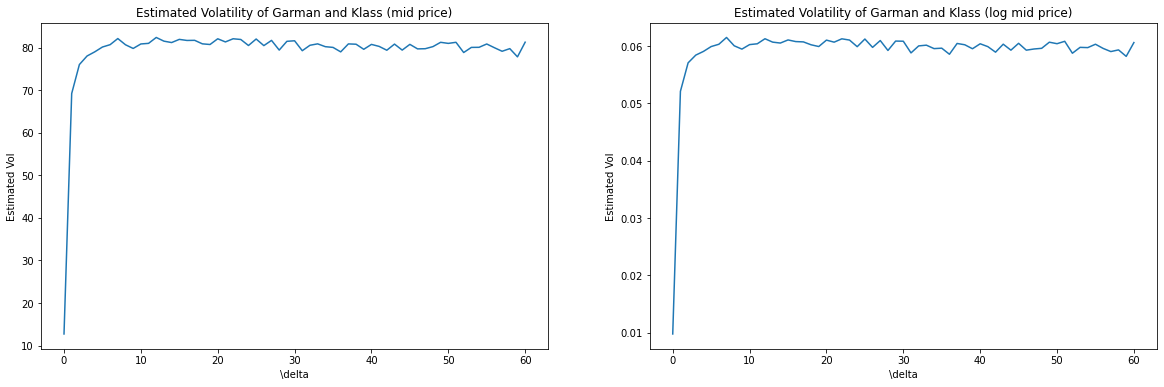

In [8]:
def PlotGK(StockName,ran,mode='normal'):
    stock  = pd.read_hdf(Chemin+'/'+StockName+'.h5')
    stock['MidPrice'] = (stock['BidPrice'] + stock['AskPrice'])/2
    if mode == 'log':
        stock['MidPrice'] = np.log(stock['MidPrice'])
#     print(stock['MidPrice'])
    ans = []
    for i in ran:
        vol = VolGK(stock['MidPrice'],str(i)+'s')
        ans.append(vol.sum())
    return ans
# T = 1000
ran = range(5, 12200, 200)
StockName = 'TOTAL'
f, axs = plt.subplots(1, 2, figsize=(20,6))
axs[0].plot(PlotGK(StockName,ran,mode='normal'))
axs[0].set_title('Estimated Volatility of Garman and Klass (mid price)')
axs[0].set_xlabel('\delta')
axs[0].set_ylabel('Estimated Vol')
axs[1].plot(PlotGK(StockName,ran,mode='log'))
axs[1].set_title('Estimated Volatility of Garman and Klass (log mid price)')
axs[1].set_xlabel('\delta')
axs[1].set_ylabel('Estimated Vol')
plt.show()

```
Commentaire:
    
On peut voir l'estimateur Garman Klass est beaucoup plus stable que l'estimateur précédent. En plus, l'estimateur Garman Klass a une tendance de croissance avec l'augementation de DeltaT.

```

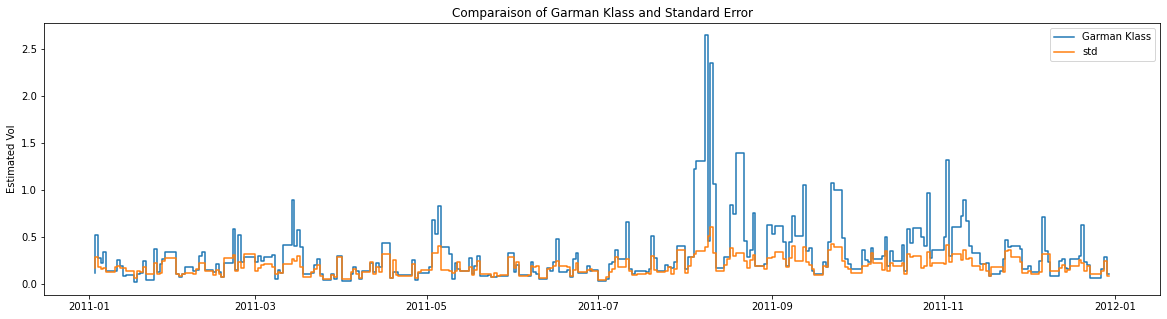

In [9]:
plt.figure(figsize=(20,5))
def GK_Std(StockName,mode='normal'):
    stock  = pd.read_hdf(Chemin+'/'+StockName+'.h5')
    stock['MidPrice'] = (stock['BidPrice'] + stock['AskPrice'])/2
    if mode == 'log':
        stock['MidPrice'] = np.log(stock['MidPrice'])
    GK = []
    std = []

    GK = VolGK(stock['MidPrice'],'D').apply(lambda x:np.nan if x <=0 else x).dropna()
    std = np.sqrt(stock['MidPrice'].resample('D').var()).apply(lambda x:np.nan if x <=0 else x).dropna()
    plt.plot(GK,label = 'Garman Klass',drawstyle='steps')
    plt.plot(std,label = 'std',drawstyle='steps')
    return 

ran = range(5, 12200, 200)
StockName = 'TOTAL'
GK_Std(StockName,mode='normal')
plt.title('Comparaison of Garman Klass and Standard Error')
plt.ylabel('Estimated Vol')
plt.legend()
plt.show()

```
Commentaire:
    
Les deux estimateur ont la même tendance, mais l'estimateur Garman Klass connaît une variance plus grande.

```

## II. Covariance Estimator and Epps Effect

### 1. "Classical" Covariance Estimator

Let $X^1= \log P^1$ and $X^2 = \log P^2$ be two log-price processes. 
$$d X^1 = \mu_t^1dt+\sigma_{t-}^1dW^1_t,$$
$$d X^2 = \mu_t^2dt+\sigma_{t-}^2dW^2_t,$$
with $d\left\langle W^1,W^2\right\rangle_t=\rho_tdt$.

Set for every $j\in{1,\ldots,T/\Delta}$, $r^1_{\Delta}(j)=X^1_{\Delta j}-X^1_{\Delta(j-1)}$ and $r^2_{\Delta}(j)=X^2_{\Delta j}-X^2_{\Delta(j-1)}$ the log-price increments.

Then the integrated covariance between the two assets reads
$$\int_0^T\rho_s\sigma^1_s\sigma^2_sds=\lim_{\Delta\to0}\sum_{j=1}^{T/\Delta}r^1_{\Delta}(j)r^2_{\Delta}(j).$$
Thus, an estimator for the realized covariance may be written as 
$$\hat{C}_R(\Delta)=\sum_{j=1}^{T/\Delta}r^1_{\Delta}(j)r^2_{\Delta}(j).$$ 
This estimator is consistent since 
$$\hat{C}_R(\Delta)\overset{\mathbb{P}}{\underset{\Delta\to0}{\longrightarrow}}\int_0^T\rho_s\sigma^1_s\sigma^2_sds.$$ 

The problem is that we must have synchronous data, but the quotations and transactions are asynchronous.

### 2. Previous Tick Estimator

Assume now that we observe $P^1$ at times $(T^1_j)_{j\geq1}$ and $P^2$ at times $(T^2_j)_{j\geq1}$. Therefore we design 
$$\bar{P}^1_t=P_{T^1_j} \quad\mbox{for }t\in[T^1_j,T^1_{j+1})$$
and
$$\bar{P}^2_t=P_{T^2_j} \quad\mbox{for }t\in[T^2_j,T^1_{j+1}).$$
Then 
$$\bar{X}^1_t=\log \bar{P}^1_t \quad\mbox{and}\quad\bar{X}^2_t=\log \bar{P}^2_t/$$

For a given $\Delta$, the previous tick covariation estimator is
$$\bar{C}_R(\Delta)=\sum_{j=1}^{T/\Delta}\left(\bar{X}^1_{\Delta j}-\bar{X}^1_{\Delta (j-1)}\right)\left(\bar{X}^2_{\Delta j}-\bar{X}^2_{\Delta (j-1)}\right).$$

### 3. Epps Effect

Epps (1979): "Correlations among price changes [...] are found to decrease with the length of the interval for which the price changes are measured."
Many explanations were proposed
- systematic bias for this estimator,
- "lead-lag" effect for the assets in the same sector,
- asynchronicity of transactions,
- "tick" effect and other microstructure effects.

**Example.** Assume that $X^1$ and $X^2$ are two Brownian motions with correlation $\rho$ and the trade times are arrival times of two independent Poisson processes. Then, one can show that
$$\mathbb{E}[\bar{C}_R(\Delta)]\underset{\Delta\to0}{\longrightarrow}0.$$

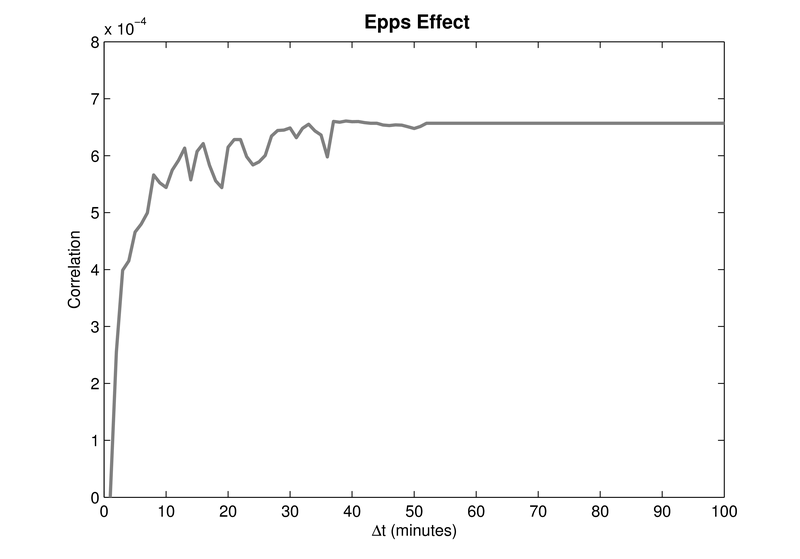

In [10]:
Image(filename='imgs/EppsEffect.png', width=500)

_Estimator for the correlation between Total and France Telecom on Euronext Paris on the period from 23/07/2012 to 27/07/2012 as a function of time discretization step._

<font color='blue'>**To do.** Plot $\hat{C}(\Delta)$ with respect to $\Delta$ (in minutes or seconds) for a couple of asset on the same exchange (using the mid-price and the log-mid-price). Same work for the correlation. Comment the results.</font>

In [11]:
def calcul_corr(PriceSec1,PriceSec2,deltaT):
    sampled1 = PriceSec1[::deltaT]
    sampled2 = PriceSec2[::deltaT]
    diff_somme = ((sampled1 - sampled1.shift(-1))*(sampled2 - sampled2.shift(-1))).fillna(0)
    return diff_somme.sum()

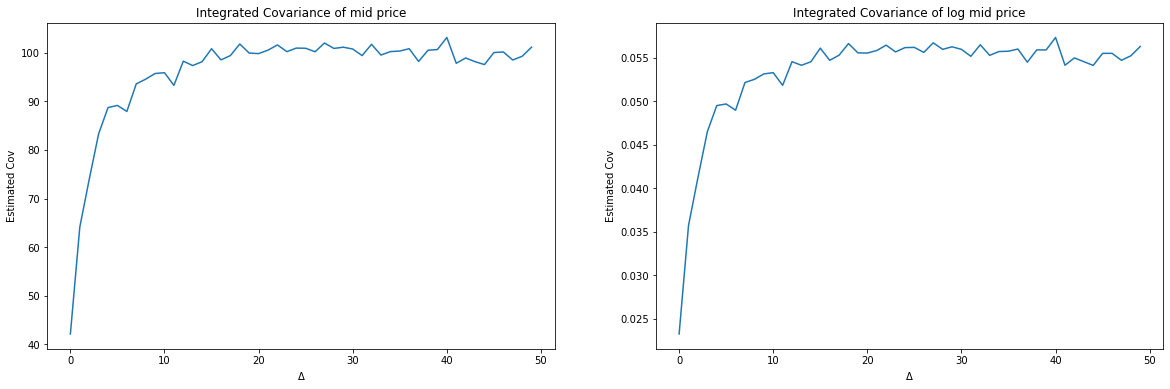

In [12]:
def Epps(StockName1,StockName2,ran,mode='normal'):
    stock1  = pd.read_hdf(Chemin+'/'+StockName1+'.h5')
    stock1['MidPrice'] = (stock1['BidPrice'] + stock1['AskPrice'])/2
    PriceSec1 = stock1['MidPrice'].resample('1s').first().fillna(method='ffill')
    
    
    stock2  = pd.read_hdf(Chemin+'/'+StockName2+'.h5')
    stock2['MidPrice'] = (stock2['BidPrice'] + stock2['AskPrice'])/2
    PriceSec2 = stock2['MidPrice'].resample('1s').first().fillna(method='ffill')
    
    if mode == 'log':
        PriceSec1 = np.log(PriceSec1)
        PriceSec2 = np.log(PriceSec2)
    ans = []

    for i in ran:
        ans.append(calcul_corr(PriceSec1,PriceSec2,i))
    return ans
# T = 1000
ran = range(1, 200,4)
StockName1 = 'TOTAL'
StockName2 = 'SANOFI'

f, axs = plt.subplots(1, 2, figsize=(20,6))

axs[0].plot(Epps(StockName1,StockName2,ran,mode='normal'))
axs[0].set_title('Integrated Covariance of mid price')
axs[0].set_xlabel('$\Delta$')
axs[0].set_ylabel('Estimated Cov')

axs[1].plot(Epps(StockName1,StockName2,ran,mode='log'))
axs[1].set_title('Integrated Covariance of log mid price')
axs[1].set_xlabel('$\Delta$')
axs[1].set_ylabel('Estimated Cov')

plt.show()

```
Commentaire:
    
Epps Effect est bien reproduit dans les graphes. La covariance décroît avec la diminuation de DeltaT.
```

The correlation estimator for high-frequency data is studied in many publications, for example Hayashi & Yoshida or Zhang.

### 4. Hayashi-Yoshida Estimator

Let $I^1_i=(T^1_i,T^1_{i+1}]$, $i\geq1$, and $I^2_j=(T^2_j,T^2_{j+1}]$, $j\geq1$.

The cumulative covariance estimator of Hayashi-Yoshida reads
$$U_n=\sum_{i,j}\Delta P^1(I^1_i)\Delta P^2(I^2_j)\mathbb{1}_{\{I^1_i\cap I^2_j\neq\emptyset\}}.$$

That is, the product of any pair of increments $\Delta P^1(I^1_i)$ and $\Delta P^2(I^2_j)$ will make a contribution to the summation only when the respective observation intervals $I^1_i$ and $I^2_i$ are overlapping.

This estimator does not need any selection of $\Delta$ and is convergent if the arrival times are independent from the price.

Then, they define two associated correlation estimators
- if $\sigma_1$ and $\sigma_2$ are known,
$$R^1_n=\frac1T\frac{\sum_{i,j}\Delta P^1(I^1_i)\Delta P^2(I^2_j)\mathbb{1}_{\{I^1_i\cap I^2_j\neq\emptyset\}}}{\sigma_1\sigma_2},$$
- if $\sigma_1$ and $\sigma_2$ are known/unknown,
$$R^2_n=\frac{\sum_{i,j}\Delta P^1(I^1_i)\Delta P^2(I^2_j)\mathbb{1}_{\{I^1_i\cap I^2_j\neq\emptyset\}}}{\sqrt{\sum_i\Delta P^1(I^1_i)^2}\sqrt{\sum_j\Delta P^2(I^2_j)^2}}.$$
Under the same conditions as for $U_n$, $R^1$ and $R^2$ are consistent for $\rho$ as $n\to\infty$.

**Remarque.** This estimator is nevertheless not robust to microstructure effects.

<font color='blue'>**To do.** Compute the daily Hayashi-Yoshida estimator on your couple of assets and compare it to classical estimator on one month you choose.</font>

Choose $T_i$ as sampled from poisson process

In [13]:
def random_times(start, end, p_lambda):
    n = np.random.poisson(lam=p_lambda, size=1)
    start_u = start.value//10**9
    end_u = end.value//10**9
    return pd.to_datetime(sorted(np.random.randint(start_u, end_u, n)), unit='s').insert(0, start)

In [14]:
def generate_poisson_sample(df_trades_1_date, t_intervals_1):
    """
    return a numpy array
    """
    df_trades_1_date = df_trades_1_date.reset_index().drop_duplicates(
        subset=["Time"], keep="first").set_index("Time").loc[:, ["TradedPrice"]]
    # compute the resampled price defined by the intervals
    trades_resamp_1 = np.zeros(shape=len(t_intervals_1))
    ind_1 = 0
    for i in range(len(t_intervals_1)):
        while ind_1 < df_trades_1_date.shape[0] and df_trades_1_date.index[ind_1] < t_intervals_1[i]:
            ind_1 += 1
        if ind_1 < df_trades_1_date.shape[0]: 
            trades_resamp_1[i] = df_trades_1_date.iloc[ind_1, 0]
        else:
            trades_resamp_1[i] = trades_resamp_1[i - 1]
    return trades_resamp_1

In [22]:
def compute_HY(df_trades_1, df_trades_2, p_lambda):
    """
    Compute the Hayashi-Yoshida Estimator
    Use two pointers
    Complexity O(n)
    """
    
    rhos = []
    for date in df_trades_1.index.unique(level=0):
        cov, var1, var2 = 0, 0, 0
        # organize the data and generate samples
        open_time, close_time = date.replace(hour=9, minute=0), date.replace(hour=17, minute=30)
        t_intervals_1, t_intervals_2 = \
            random_times(open_time, close_time, p_lambda), random_times(open_time, close_time, p_lambda)
        
        df_trades_date_1, df_trades_date_2 = df_trades_1.loc[date], df_trades_2.loc[date]

        trades_resamp_1, trades_resamp_2 = \
            generate_poisson_sample(df_trades_date_1, t_intervals_1), generate_poisson_sample(df_trades_date_2, t_intervals_2)
        trades_resamp_1 = np.log(trades_resamp_1)
        trades_resamp_2 = np.log(trades_resamp_2)
        # compute the covariance
        j = 0
        t_intervals_2_it = t_intervals_2.insert(-1, close_time) # sentinel
        assert(t_intervals_1.shape == trades_resamp_1.shape)
        for i in range(1, trades_resamp_1.shape[0]):
            while j < t_intervals_2_it.shape[0] and t_intervals_2_it[j] < t_intervals_1[i]: 
                cov += (trades_resamp_2[j + 1] - trades_resamp_2[j])*(trades_resamp_1[i] - trades_resamp_1[i - 1])
                j += 1

        # compute the variance
        var1 += np.sum((trades_resamp_1[1:] - trades_resamp_1[:-1])**2)
        var2 += np.sum((trades_resamp_2[1:] - trades_resamp_2[:-1])**2)
        assert(var1 > 0)
        assert(var2 > 0)
        rhos.append(cov / np.sqrt(var1 * var2))
    return rhos

```
We decided to use the first month as an example
```

In [23]:
# we selected SANOFI and LVMH
df_trades_1 = pd.read_hdf("Data/SANOFI.h5")
df_trades_1.loc[:, "Date"] = df_trades_1.index.date
df_trades_1.loc[:, "Month"] = df_trades_1.index.month

df_trades_2 = pd.read_hdf("Data/TOTAL.h5")
df_trades_2.loc[:, "Date"] = df_trades_2.index.date
df_trades_2.loc[:, "Month"] = df_trades_2.index.month

df_trades_1 = df_trades_1.reset_index().drop_duplicates(subset=["Time"])\
                .set_index(keys=['Month', 'Date', 'Time']).loc[1]
df_trades_2 = df_trades_2.reset_index().drop_duplicates(subset=["Time"])\
                .set_index(keys=['Month', 'Date', 'Time']).loc[1]

In [37]:
# choose price change as Ti 
rhos_HY_determ = []
for date in df_trades_1.index.unique(level=0):
    cov, var1, var2 = 0, 0, 0
    df_trades_1_date = df_trades_1.loc[date].loc[:, ["TradedPrice"]].fillna(method="ffill")
    df_trades_2_date = df_trades_2.loc[date].loc[:, ["TradedPrice"]].fillna(method="ffill")
    
    df_trades_1_date.TradedPrice = np.log(df_trades_1_date.TradedPrice)
    df_trades_2_date.TradedPrice = np.log(df_trades_2_date.TradedPrice)
    
    j = 0
    while df_trades_2_date.index[j] < df_trades_1_date.index[0]:
        j += 1
    for i in range(1, df_trades_1_date.shape[0]):
        while j + 1 < df_trades_2_date.shape[0] and df_trades_2_date.index[j] < df_trades_1_date.index[i]:
            cov += (df_trades_2_date.iloc[j + 1, 0] - df_trades_2_date.iloc[j, 0])\
                        *(df_trades_1_date.iloc[i, 0] - df_trades_1_date.iloc[i - 1, 0])
            j += 1
            
    var1 = df_trades_1_date.TradedPrice.diff().pow(2).sum()
    var2 = df_trades_2_date.TradedPrice.diff().pow(2).sum()
    
    rhos_HY_determ.append(cov / np.sqrt(var1 * var2))

In [43]:
rhos_HY_determ

[0.0540919892699933,
 0.10043434131112353,
 0.13492738176152017,
 0.07916160895218932,
 0.1090128661628984,
 0.1611962653471673,
 0.17475531490967153,
 0.0617037802116299,
 0.11244777519364048,
 0.10285403691020509,
 0.08207796050533606,
 0.07238866588356065,
 0.15132661670257902,
 0.15047546168245937,
 0.13796251676393353,
 0.14134664235795746,
 0.11492745583972276,
 0.06688328156049822,
 0.1109808062766076,
 0.019742412212289933]

In [25]:
def compute_corr_IC(df_trades_1, df_trades_2):
    rhos_IC = []
    for date in df_trades_1.index.unique(level = 0):
        df_trades_date_1, df_trades_date_2 = df_trades_1.loc[date], df_trades_2.loc[date]
        PriceSec1 = df_trades_date_1['TradedPrice'].resample('1s').first().fillna(method='ffill')
        PriceSec2 = df_trades_date_2['TradedPrice'].resample('1s').first().fillna(method='ffill')
        rhos_IC.append(PriceSec1.corr(PriceSec2))
    return rhos_IC

rhos_IC = compute_corr_IC(df_trades_1, df_trades_2)

In [26]:
p_lambda = 1500
rhos_HY = compute_HY(df_trades_1, df_trades_2, p_lambda)

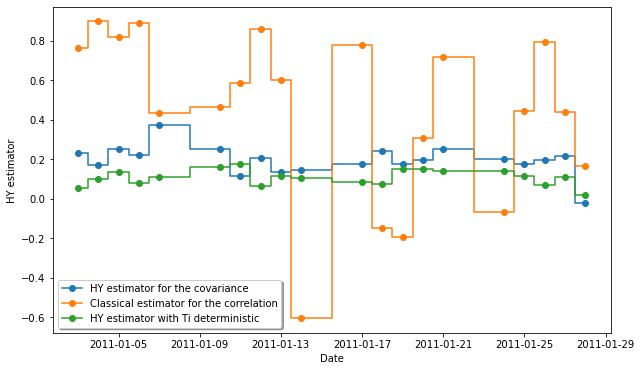

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(df_trades_1.index.unique(level=0), rhos_HY, marker='o', label="HY estimator for the covariance", drawstyle="steps-mid")
plt.plot(df_trades_1.index.unique(level=0), rhos_IC, marker='o', label="Classical estimator for the correlation", drawstyle="steps-mid")
plt.plot(df_trades_1.index.unique(level=0), rhos_HY_determ, marker='o', label="HY estimator with Ti deterministic", drawstyle="steps-mid")

plt.legend(shadow=True, fancybox=True)
plt.xlabel("Date")
plt.ylabel("HY estimator")
plt.show()

```
The daily Hayashi-Yoshida estimator is shown on the figure above (on the first month), together with classical estimator of price for comparaison. 

We observe that the classical estimator has a much greater variance than that of Hayashi-Yoshida estimator and much more biased according to the trading days
```

```
The resampled prices are the following (selected one day) 
```

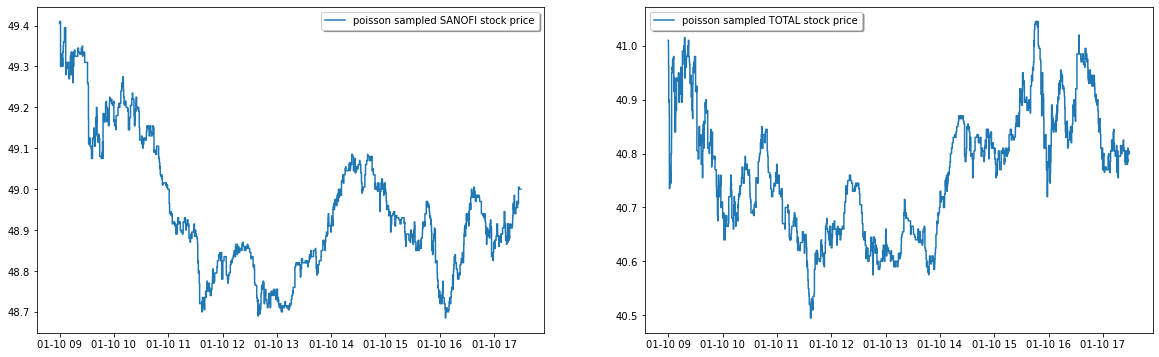

In [44]:
date = df_trades_1.index.unique(level=0)[5]
open_time, close_time = date.replace(hour=9, minute=0), date.replace(hour=17, minute=30)
t_intervals_1, t_intervals_2 = \
    random_times(open_time, close_time, p_lambda), random_times(open_time, close_time, p_lambda)

df_trades_date_1, df_trades_date_2 = df_trades_1.loc[date], df_trades_2.loc[date]

trades_resamp_1, trades_resamp_2 = \
    generate_poisson_sample(df_trades_date_1, t_intervals_1), generate_poisson_sample(df_trades_date_2, t_intervals_2)

f, axs = plt.subplots(1, 2, figsize=(20,6))
axs[0].plot(t_intervals_1, trades_resamp_1, drawstyle='steps', label="poisson sampled SANOFI stock price")
axs[0].legend(shadow=True, fancybox=True)
axs[1].plot(t_intervals_2, trades_resamp_2, drawstyle='steps', label="poisson sampled TOTAL stock price")
axs[1].legend(shadow=True, fancybox=True)
plt.show()

## III. Link between bid-ask spread and volatility per trade

The volatility can be seen as a measure quantifying how much information flows into a price. In practice, such information is correlated with an order flow that either anticipates or causes successive price changes. 
Mechanically, the effect on price of a trade can be of two types according to the tick size:
- for a large tick asset, the bid-ask spread is always equal to one tick, hence the average price change induced by a trade is fixed by the tick size and the probability of depleting a queue. 
- Conversely, in the regime of small tick size, all the trades trigger a price change, so that the average price change is fixed by the average spread. 
In both cases, one has that a trade can induce a price change with positive probability.

### 1. Relation for small tick assets

It is well-known that spread and volatility are intimately related : while the spread fixes the profit per trade of market makers, the volatility determines the adverse selection that they needs to face.
In any model in which market makers break even, one needs to have an equation fixing the relation between bid-ask spread and volatility.
This relation has been the subject of several models trying to justify it microscopically, while empirically this has been analyzed in several works.
In the simplest possible model of Madhavan, Richardson and Roomans (MRR), one obtains that
$$\varphi=c\sigma_{mid} N^{-1/2},$$
where $\varphi$ is the spread, $\sigma_{mid}$ is the mid-price volatility, $N$ the number of trades and $c > 0$.

### 2. Relation for large tick assets

Dayri and Rosenbaum developed a new approach to exhibit the relationship between bid-ask spread and volatility per trade for large tick assets. The model derives from the one with uncertainty zones introduced in~\cite{RobRos}. They assume the existence of a {\em latent price} representing the opinion of market participants on the ``true'' price and modeled by a continuous Brownian semi-martingale $(x_t)_{t\geq0}$. Let $\alpha$ be the tick size of the asset. The areas of uncertainty are defined as bands around the middle of the tick size with width $2\eta\alpha$, $0<\eta<1$. The dynamics of the price of the last transaction $p_t$ is obtained as a function of the latent price and areas of uncertainty. The bid-ask spread is assumed to be constant and equal to the tick size $\alpha$. 

The authors define alternating (resp. continuity) of a tick size as a jump in the price of a tick size whose direction is adverse (resp. the same) than the previous jump. The number of alternations and continuities of a tick size respectively on the period $[0,t]$. The consistent estimator of $\eta$ on $[0,t]$ is then
$$\widehat{\eta}_{\alpha,t}=\frac{N_{\alpha,t}^{(c)}}{2N_{\alpha,t}^{(a)}}.$$
For volatility, first note that this model allows to find the value of the latent price on the date of $\tau_i$ of the $i^{th}$ price change by the simple relationship
$$x_{\tau_i}=p_{\tau_i}-\mbox{sign}\left(p_{\tau_i}-p_{\tau_{i-1}}\right)\left(\frac12-\eta\right)\alpha.$$
As we can estimate $\eta$, we can then find out $x_{\tau_i}$ from $p_{\tau_{i-1}}$ and $p_{\tau_i}$. For example, the realized variance on estimated values of the efficient price on $[0,t]$
$$\widehat{\sigma^2_{LP,t}}=\sum_{\tau_i\leq t}\left(\widehat{x}_{\tau_i}-\widehat{x}_{\tau_{i-1}}\right)^2,$$
where $\widehat{x}_{\tau_i}=p_{\tau_i}-\mbox{sign}\left(p_{\tau_i}-p_{\tau_{i-1}}\right)\left(\frac12-\widehat{\eta}_{\alpha,t}\right)\alpha$, is an estimator of the integrated variance of the latent price over $[0,t]$ $\int_0^t\sigma_s^2ds$. Now we set $\widehat{\sigma}_{LP}=\sqrt{\widehat{\sigma^2_{[0,t]}}}$ and we define the volatility per trade by $\widehat{\sigma}_{LP}/\sqrt{N}$ where $N:=N_{[0,t]}$ denotes the total number of trades on $[0,t]$. Without making any differences between parameters and their estimates, we get then the following relationship
\begin{equation}\label{EtaLP}
\eta\alpha\approx c\frac{\sigma_{LP}}{\sqrt{N}}.
\end{equation}
Market participants have a certain resolution, or precision at which they infer the efficient price $x_t$. $\eta$ quantifies this resolution: when $\eta$ is close to 1/2, the resolution is close to the tick value. The quantity $2\eta\alpha$ can be seen as an implicit spread: $\eta$ can indeed be viewed as a suitable measure for the tick size.


<font color='blue'>**To do.** 1. Compute $\eta$, $\alpha$ and $\sigma_{LP}$ on a daily basis for each asset. Compare the implicit spread and the real spread. Idem for the volatilities of both latent price and traded price. Comment. 

2. Implement the linear regression for large tick asset and compare to the results of the previous practical work.</font>

In [20]:
allstocks = {
    0:['CANON', 'PANASONIC', 'SONY'],
    1:['AMAZON', 'APPLE', 'GOOGLE'],
    2:['SANOFI', 'BOUYGUES', 'LVMH', "TOTAL"],
}
simple_stocks = ['CANON', 'PANASONIC', 'SONY','AMAZON', 'APPLE', 'GOOGLE','SANOFI', 'BOUYGUES', 'LVMH', "TOTAL"]

In [21]:
def calcul_alpha(stock):
    alpha = stock['Spread'].resample('D').mean()
    alpha = alpha.dropna()
    return alpha

def calcul_ita(stock):
    stock['MidP+1'] = stock['MidPrice'].shift(1)
    stock['MidP+2'] = stock['MidPrice'].shift(2)
    direc = ((stock['MidPrice'] - stock['MidP+1'])*(stock['MidP+1']-stock['MidP+2'])).apply(np.sign).dropna()
    direc = direc.resample('D')
    s = direc.count()
    abso = direc.sum()
    alter = (s - abso)/2
    conti = (s+abso)/2
    ita = (conti/(2*alter)).apply(lambda x:min(x,0.5))
    ita = ita.apply(lambda x:np.nan if x <=0 else x).dropna()
#     print(ita)
#     ita.mean()
    return ita

    
def calcul_vol_latent(stock,alpha,ita):
    alpha_m = alpha.mean()
    ita_m = ita.mean()
    stock['X'] = stock['MidPrice'] - (stock['MidPrice'] - stock['MidP+1']).apply(np.sign) * alpha_m*(0.5 - ita_m)
    diff_somme = ((stock['X'] - stock['X'].shift(-1))**2).dropna()
    vol = diff_somme.resample('D').sum().apply(lambda x:np.nan if x <=0 else x).dropna()
    return vol


def LM(k,StockName):
#     StockName = 'TOTAL'
    stock  = pd.read_hdf(Chemin+'/'+StockName+'.h5')
    stock['MidPrice'] = (stock['BidPrice'] + stock['AskPrice'])/2
    stock['Spread'] = stock['AskPrice'] - stock['BidPrice']
    TradeNums = stock['MidPrice'].resample('D').count().apply(lambda x:np.nan if x <=0 else x).dropna()
    
    alpha = calcul_alpha(stock)
    
    stock = stock[stock['MidPrice'] != stock['MidPrice'].shift(1)]
    ita = calcul_ita(stock)
    
    vol = calcul_vol_latent(stock,alpha,ita)
    
    y = ita*alpha
    x = (vol/TradeNums).apply(np.sqrt)
    x = sm.add_constant(x)
    # Fonction pour la régression de y sur x
    rlm_model = sm.RLM(y, x, M=sm.robust.norms.HuberT())
    model = rlm_model.fit()

    # Pour accéder aux coefficients
    print(f"{StockName}: {model.params['const'],model.params[0]}")
    axs[k].plot((vol/TradeNums).apply(np.sqrt),ita*alpha,'*',label = StockName)
    axs[k].legend(shadow=True, fancybox=True)
    return

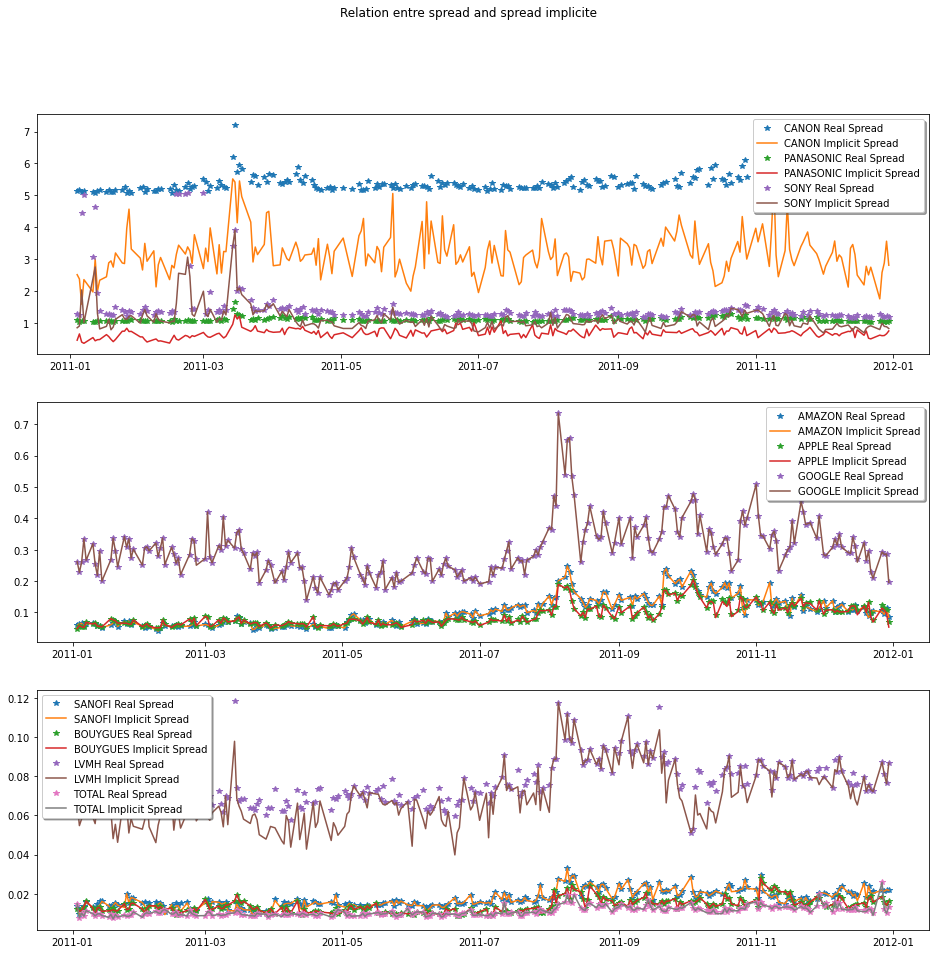

In [22]:
def plot_Spread(k,StockName):
    stock  = pd.read_hdf(Chemin+'/'+StockName+'.h5')
    stock['MidPrice'] = (stock['BidPrice'] + stock['AskPrice'])/2
    stock['Spread'] = stock['AskPrice'] - stock['BidPrice']
    TradeNums = stock['MidPrice'].resample('D').count().apply(lambda x:np.nan if x <=0 else x).dropna()
    
    alpha = calcul_alpha(stock)
    
    stock = stock[stock['MidPrice'] != stock['MidPrice'].shift(1)]
    ita = calcul_ita(stock)
    
    im_alpha = 2*ita*alpha
    axs[k].plot(alpha,'*',label = StockName + ' Real Spread')
    axs[k].plot(im_alpha,'-',label = StockName + ' Implicit Spread')
    axs[k].legend(shadow=True, fancybox=True)

    return 

f, axs = plt.subplots(3, 1, figsize=(16,15))
f.suptitle("Relation entre spread and spread implicite")
for k, stocks in allstocks.items():
    for StockName in stocks:
        plot_Spread(k,StockName)

```
Commentaire:
    
    Ici, nous avons la comparaison de real spread et spread implicite. Nous pouvons voir que les deux valeurs sont assez différentes pour CANON, SONY, PANASONIC et LVMH. Pour les restes, ils sont donc des actifs à gros tick.
```

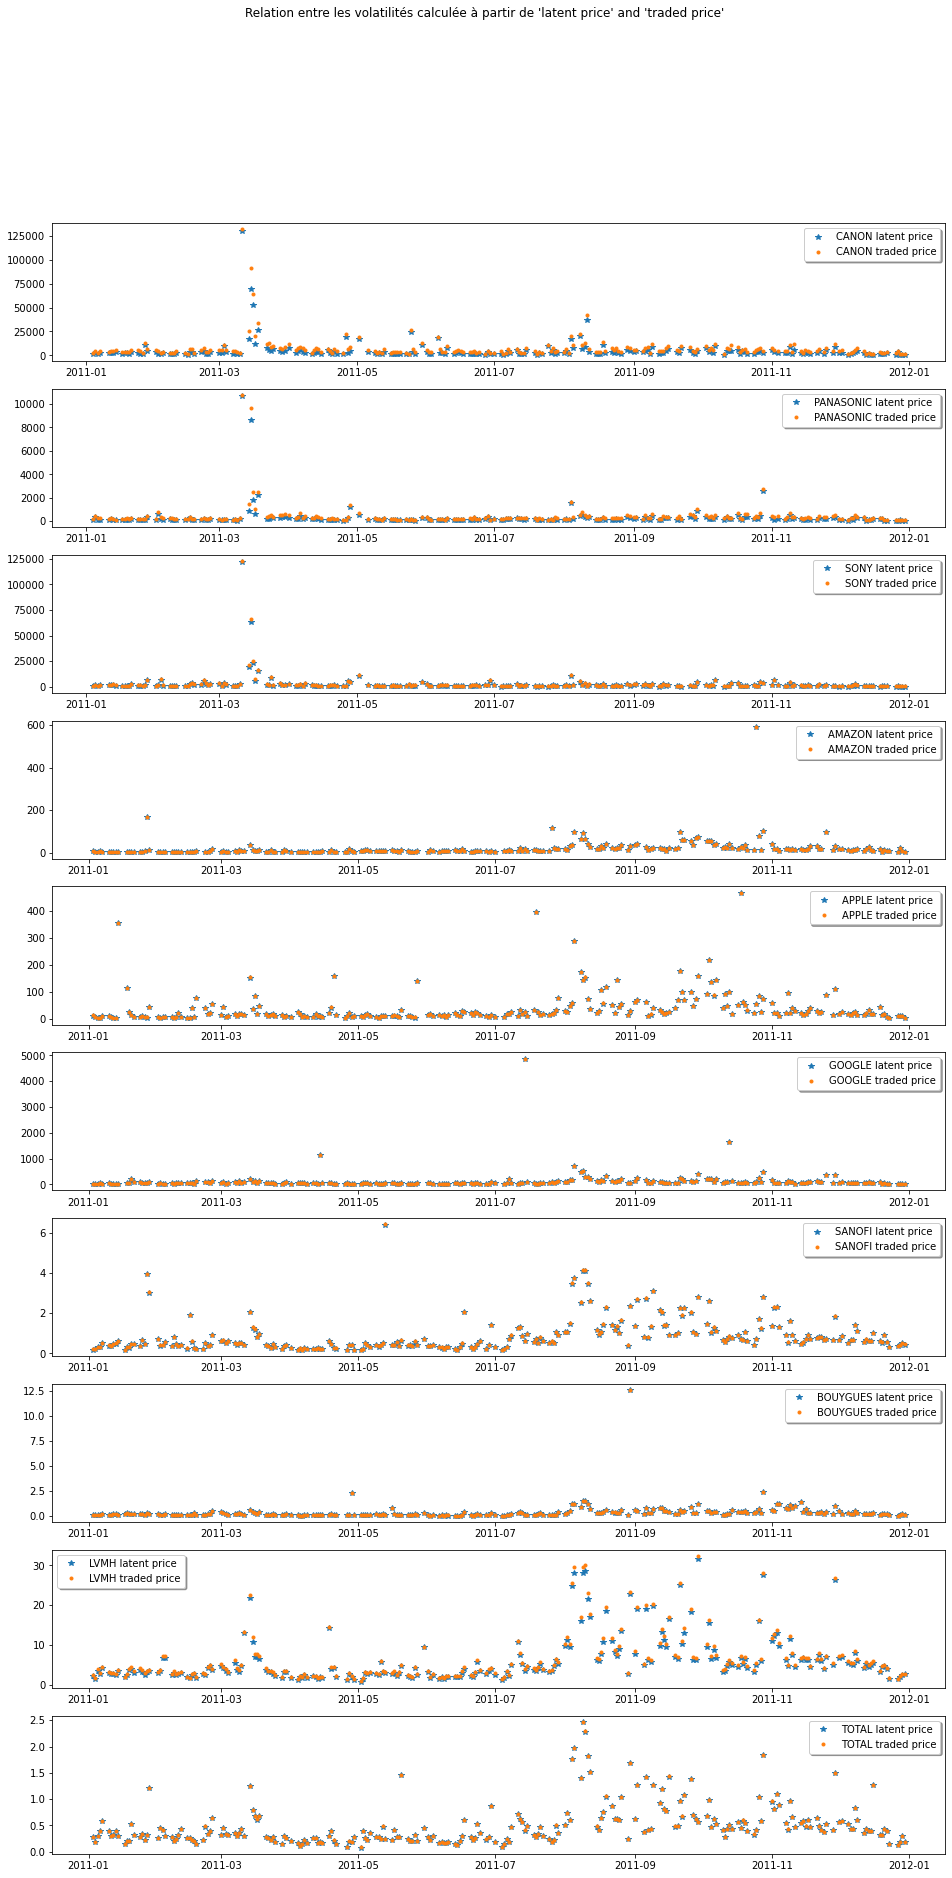

In [23]:
def plot_vol(k,StockName):
    stock  = pd.read_hdf(Chemin+'/'+StockName+'.h5')
    stock['MidPrice'] = (stock['BidPrice'] + stock['AskPrice'])/2
    stock['Spread'] = stock['AskPrice'] - stock['BidPrice']
    TradeNums = stock['MidPrice'].resample('D').count().apply(lambda x:np.nan if x <=0 else x).dropna()
    
    alpha = calcul_alpha(stock)
    
    stock = stock[stock['MidPrice'] != stock['MidPrice'].shift(1)]
    ita = calcul_ita(stock)
    
    vol = calcul_vol_latent(stock,alpha,ita)
    
    diff_somme = ((stock['MidPrice'] - stock['MidPrice'].shift(-1))**2).dropna()
    vol_tr = diff_somme.resample('D').sum().apply(lambda x:np.nan if x <=0 else x).dropna()

    axs[k].plot(vol,'*',label = StockName + ' latent price')
    axs[k].plot(vol_tr,'.',label = StockName + ' traded price')
    axs[k].legend(shadow=True, fancybox=True)

    return 

f, axs = plt.subplots(10, 1, figsize=(16,30))
f.suptitle("Relation entre les volatilités calculée à partir de 'latent price' and 'traded price'")

for i,stock in enumerate(simple_stocks):
#     print(stock,i)
    plot_vol(i,stock)

```
Commentaire:
    
    Ici, nous avons la comparaison de volatilité calculée à partir de 'latent price' and 'traded price'. Comme pour les deux valeurs de spread, nous pouvons voir que les deux valeurs de volatilité sont assez différentes pour CANON, SONY, PANASONIC et LVMH, ce qui est cohérent par rapport aux résultats du spread.
```

AMAZON: (0.004855147212911266, 1.2011170547015522)
APPLE: (0.01987374186155995, 0.7445662211572845)
GOOGLE: (0.08966091748357374, 0.55281106325709)
SANOFI: (0.0039011405813809985, 0.6526768338715214)
BOUYGUES: (0.00337483732869089, 0.5425868137869194)
TOTAL: (0.0025592756938584652, 0.6060984786796558)


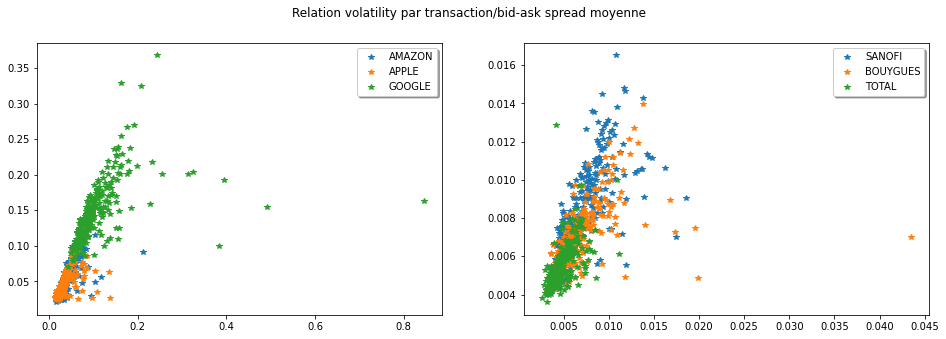

In [24]:
allstocks_gros = {
    0:['AMAZON', 'APPLE', 'GOOGLE'],
    1:['SANOFI', 'BOUYGUES', "TOTAL"],
}
f, axs = plt.subplots(1, 2, figsize=(16,5))
f.suptitle("Relation volatility par transaction/bid-ask spread moyenne")

for k, stocks in allstocks_gros.items():
#     print(stocks)
    for StockName in stocks:
#         print(StockName)
        LM(k,StockName)

```
Ici, nous avons fait regression pour les actifs à gros tick. 

À partir des graphes, nous constatons que les pentes sont plus ou moins proches pour les actifs à gros tick. Puis, à partir des valeurs de pente calculées(deuxième chiffre des listes), les valeurs des pentes sont aussi proches. Nous pouvons dire que $c$ est pareil pour tous les actifs à gros tick.

En plus, les ordonnée à l'origine sont proches de 0. Le modèle est donc vérifié par les données réelles.

Par rapport aux résultats du dernier TP, on doit dire qu'ici le modèle est plus sophistiqué et mieux vérifié par les données, parce qu'on a éliminé les actif à petit tick.

```